# KNN and ANN

## 3.1 KNN

In [1]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from collections import Counter

In [2]:
def compute_distances(query, database, metric='euclidean'):
    if metric == 'euclidean':
        return euclidean_distances(query, database)
    else: # metric == 'cosine':
        return cosine_distances(query, database)

def knn(query, database, k=1, metric='euclidean'):
    distances = compute_distances(query, database, metric)
    return np.argsort(distances, axis=1)[:, :k]

def accuracy(predictions, true_labels):
    return np.mean(predictions == true_labels)

def mean_reciprocal_rank(ranks):
    return np.mean([1.0 / (rank + 1) for rank in ranks])

def precision_at_k(retrieved, relevant, k=100):
    return np.mean([len(set(r[:k]) & set(rel)) / k for r, rel in zip(retrieved, relevant)])

def hit_rate(retrieved, relevant):
    return np.mean([bool(set(r) & set(rel)) for r, rel in zip(retrieved, relevant)])


In [3]:
import torch

test_embeddings = torch.load("data/test_embeddings.pth").cpu().numpy()
test_labels = torch.load("data/test_labels.pth").cpu().numpy()
text_embeddings = torch.load("data/text_embedding.pth").cpu().numpy()
train_embeddings = torch.load("data/train_embeddings.pth").cpu().numpy()
train_labels = torch.load("data/train_labels.pth").cpu().numpy()


### Task 1: Classification

`Part A:` Classify each image in the test set using the labels of the k nearest neighbours from the train
set. Report the accuracy for 3 different values of k(1, 5, 10) and cosine and eucledian distance
metrics (2 Marks).

In [4]:
test_embeddings

array([[ 0.02703163,  0.02144752, -0.02135308, ...,  0.03271306,
         0.00272371,  0.00788133],
       [ 0.06078386,  0.00921593,  0.00353527, ...,  0.05257338,
        -0.01536452, -0.01068242],
       [ 0.00997146,  0.00219643,  0.00162613, ...,  0.07562945,
        -0.0286385 ,  0.03985597],
       ...,
       [ 0.01001741,  0.01282956, -0.01528638, ...,  0.06088507,
         0.01944811,  0.00726219],
       [ 0.06072288,  0.03743307, -0.00819483, ...,  0.03468397,
         0.00613324,  0.01689602],
       [ 0.01886884,  0.01738086, -0.00040511, ...,  0.0210179 ,
         0.00670911,  0.01817487]], dtype=float32)

In [5]:
distances = compute_distances(test_embeddings, train_embeddings, metric = 'euclidean')

In [6]:
distances.shape

(10000, 50000)

In [42]:
distances.max()

np.float32(1.1220006)

In [7]:
k_1_values = knn(test_embeddings, train_embeddings, k = 1, metric = "euclidean")

In [36]:
k_1_values

array([[13080],
       [16435],
       [13923],
       ...,
       [23042],
       [46678],
       [41755]])

In [25]:
labels_semantics = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])

In [26]:
len(labels_semantics)

10

In [27]:
k_1_values.reshape(1, len(k_1_values))[0]

array([13080, 16435, 13923, ..., 23042, 46678, 41755])

In [30]:
# mapped = labels_semantics[test_labels[k_1_values.reshape(1, len(k_1_values))]]

index_to_labels = train_labels[k_1_values.reshape(1, len(k_1_values))[0]]

mapped = labels_semantics[np.array(index_to_labels)]
# mapped = train_labels[k_1_values.reshape(1, len(k_1_values))[0]]

In [31]:
mapped

array(['frog', 'ship', 'ship', ..., 'dog', 'airplane', 'horse'],
      dtype='<U10')

`Part B:` Instead of using the train set to predict the labels, now use the text embeddings to predict the
labels. Using k = 1, get the text embedding closest to each image and predict the accuracy (2
Marks)

In [44]:
distances_text = compute_distances(test_embeddings, text_embeddings, metric = "euclidean")
k_1_values_text = knn(test_embeddings, text_embeddings, k = 1, metric = "euclidean")

In [49]:
mapped_text = labels_semantics[np.array(k_1_values_text)]

In [51]:
mapped_text

array([['cat'],
       ['ship'],
       ['ship'],
       ...,
       ['dog'],
       ['airplane'],
       ['horse']], dtype='<U10')

#### Task 2: Retreival

`Part A:` Text to Image Retrieval: For each text embedding retrieve the 100 nearest embeddings from the
train set and report the 3 metrics: Mean reciprocal rank, precision@100 and hit rate. (2 Marks)

In [54]:
text_to_image = knn(text_embeddings, train_embeddings, k=100, metric="euclidean")

In [57]:
text_to_image.shape

(10, 100)

`Part B:` Image to Image Retrieval: For each test embedding retrieve the 100 nearest embeddings from
train set and report the metrics mentioned above. (2 Marks)

In [58]:
image_to_image = knn(test_embeddings, train_embeddings, k = 100, metric = "euclidean")

## 3.2 Locally Sensitive Hashing

#### `Task 1:` Implement LSH following the article linked above using random hyperplanes.

In [59]:
import numpy as np
import matplotlib.pyplot as plt

In [61]:
class LSH:
    def __init__(self, num_hyperplanes, dim):
        self.num_hyperplanes = num_hyperplanes
        self.dim = dim
        self.hyperplanes = np.random.randn(num_hyperplanes, dim)
        self.buckets = dict()

    def hash_vector(self, vec):
        return tuple((vec @ self.hyperplanes.T) > 0)

    def insert(self, vec, index):
        hash_key = self.hash_vector(vec)

        if hash_key not in list(self.buckets.keys()):
            self.buckets[hash_key] = []
        self.buckets[hash_key].append(index)

    def query(self, vec, k):
        hash_key = self.hash_vector(vec)
        candidates = self.buckets.get(hash_key, [])

        # there could be too many, so..
        if len(candidates) >= k:
            return np.random.choice(candidates, k, replace=False)
        
        all_candidates = list(candidates)
        for key, indices in self.buckets.items():
            if len(all_candidates) >= k:
                break
            all_candidates.extend(indices)
        
        return np.array(all_candidates[:k])

#### `Task 2:` Plot histograms showing frequency of samples in each bucket. Do this for different number of hyperplanes. What problems do you notice here?

In [62]:
import torch

test_embeddings = torch.load("data/test_embeddings.pth").cpu().numpy()
test_labels = torch.load("data/test_labels.pth").cpu().numpy()
text_embeddings = torch.load("data/text_embedding.pth").cpu().numpy()
train_embeddings = torch.load("data/train_embeddings.pth").cpu().numpy()

In [63]:
n, d = train_embeddings.shape
num_hyperplanes_list = [5, 10, 20, 50]

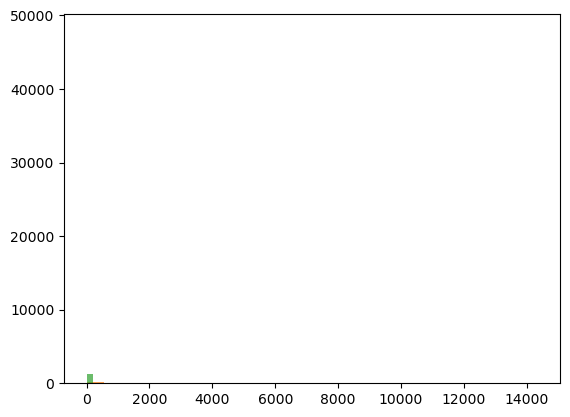

In [64]:
for num_hyperplanes in num_hyperplanes_list:
    lsh = LSH(num_hyperplanes, d)
    
    for idx, vec in enumerate(train_embeddings):
        lsh.insert(vec, idx)
    
    bucket_sizes = [len(v) for v in lsh.buckets.values()]
    plt.hist(bucket_sizes, bins=20, alpha=0.7, label=f'{num_hyperplanes} hyperplanes')

Problems that I notice here:

fill this ------------------------------------------------------------------------->>>>>>>>>>>>>>>>>>>>>>>

#### `Task 3:` Perform image to image retrieval for your choice of k and report metrics mentioned in the previous section.

In [ ]:
plt.xlabel('Bucket Size')
plt.ylabel('Frequency')
plt.legend()
plt.title('LSH Bucket Distribution')
plt.show()

test_index = 0
retrieved_indices = lsh.query(train_embeddings[test_index], k=5)

print("Retrieved Neighbors for Test Image:", retrieved_indices)

#### `Task 4:` How do these metrics change, on changing the number of hyperplanes, mention possible reasons for these.

## 3.3 IVF

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [6]:
class IVF:
    def __init__(self, k=10):
        self.k = k
        self.kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        self.inverted_index = {}
    
    def fit(self, data):
        self.kmeans.fit(data)
        labels = self.kmeans.labels_
        self.inverted_index = {i: [] for i in range(self.k)}
        
        for i, label in enumerate(labels):
            self.inverted_index[label].append(data[i])
        
        for key in self.inverted_index:
            self.inverted_index[key] = np.array(self.inverted_index[key])
    
    def search(self, query, nprobe=1, top_k=5):
        centroids = self.kmeans.cluster_centers_
        dists = cdist([query], centroids, metric='euclidean')[0]
        closest_clusters = np.argsort(dists)[:nprobe]
        
        candidates = []
        for cluster in closest_clusters:
            candidates.extend(self.inverted_index.get(cluster, []))
        
        candidates = np.array(candidates)
        if len(candidates) == 0:
            return []
        
        distances = cdist([query], candidates, metric='euclidean')[0]
        nearest_indices = np.argsort(distances)[:top_k]
        return [candidates[i] for i in nearest_indices]
    
    def plot_cluster_distribution(self):
        cluster_sizes = [len(self.inverted_index[i]) for i in range(self.k)]
        plt.bar(range(self.k), cluster_sizes)
        plt.xlabel("Cluster ID")
        plt.ylabel("Number of Points")
        plt.title("Cluster Distribution")
        plt.show()

## 3.4 Analysis